## OVERVIEW
---
* Feature Selection & Data Sampling
* Image Processing
* Data Augmentation
* Transfer Learning with Keras Xception
* Bottleneck Feature Ectraction
* Deep Learning

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

import keras
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking,GlobalAveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### DATA UTILITIES

In [2]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
!ls ~/.keras/models

xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [3]:
base_folder = '../input/celeba-dataset'
data_folder = '../input/celeba-dataset/img_align_celeba'
image_folder = '../input/celeba-dataset/img_align_celeba/img_align_celeba'

In [4]:
#read the image attributes csv file
df = pd.read_csv('../input/celeba-dataset/list_attr_celeba.csv')

In [5]:
print(df.columns)
df.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


### FEATURE SELECTION

In [6]:
df = df = df[['image_id', 'Male']]
#replace -1 to 0
df.replace(to_replace=-1, value=0, inplace=True) 

In [7]:
#add a class feature
def to_labels(x):
    if x == 0:
        return 'female'
    else:
        return 'male'

df['class'] = df.Male.apply(to_labels)
df.columns = ['filename', 'label', 'class']

In [8]:
#show new dataframe
df.head()

,filename,label,class
0,000001.jpg,0,female
1,000002.jpg,0,female
2,000003.jpg,1,male
3,000004.jpg,0,female
4,000005.jpg,0,female


### COUNTPLOT PER GENDER

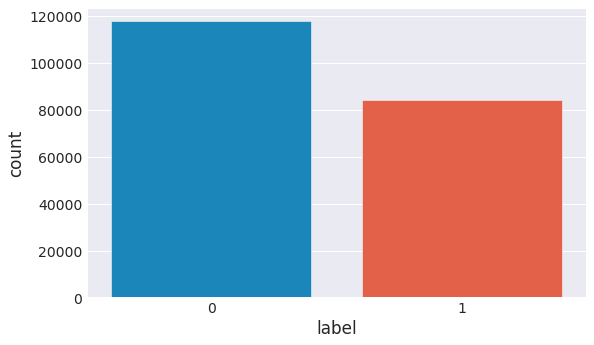

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(df.label);

### DATA SAMPLING

In [10]:
SAMPLES = 300
train_data = pd.concat([df[df['label']== i][:SAMPLES] for i in range(0,2)])
print('TRAIN DATA SHAPE: ', train_data.shape)

TRAIN DATA SHAPE:  (600, 3)


### SHOW SAMPLE IMAGES

In [11]:
# function to get an image
def read_img(filename, size):
    img = image.load_img(os.path.join(image_folder, filename), target_size=size)
    #convert image to array
    img = image.img_to_array(img) / 255
    return img

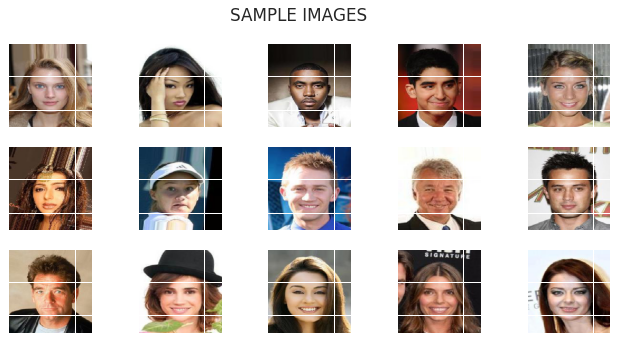

In [12]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(train_data['filename'].iloc[np.random.randint(500)], (255,255))));
plt.show();

### DATA AUGMENTATION

In [13]:
#create a imagegenerator for for augmentation
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

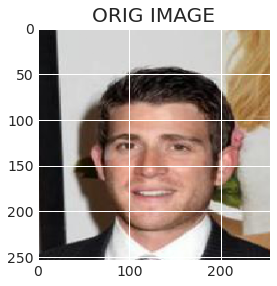

In [14]:
img = read_img(train_data['filename'].iloc[546], (255,255))
plt.title('ORIG IMAGE')
plt.imshow(img);


###### SHOW SAMPLE AUGMENTED IMAGE

In [15]:
# reshape image to 4 dimentional
img = img.reshape((1,) + img.shape)

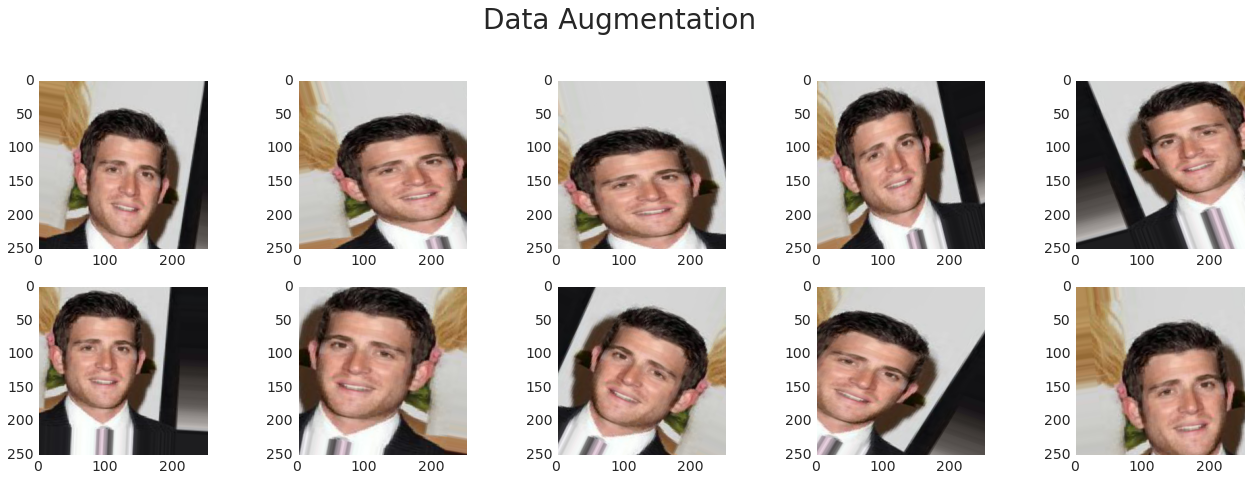

In [16]:
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)


i = 0

for batch in datagen.flow(img, batch_size=32):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(255, 255, 3));
    
    if i == 9:
        break
    i += 1
    
plt.show();

In [17]:
#split the data
X = train_data.drop(['label', 'class'], axis=1)
y = train_data['label']

train_x, train_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

### IMAGE PROCESSING

In [18]:
# function to get an image
def read_img(filename, size):
    img = image.load_img(os.path.join(image_folder, filename), target_size=size)
    #convert image to array
    img = image.img_to_array(img) / 255
    img = img.reshape((1,) + img.shape)
    return img


array_img = []
label_img = []

for i, file in tqdm(enumerate(train_x['filename'])):
    img = read_img(file, (255,255))
    label = y_train.iloc[i]
    num = 0
    for batch in datagen.flow(img, batch_size=32):
        batch = batch.reshape(255,255,3)
        array_img.append(batch)
        label_img.append(label)
        if num == 4:
            break
        num=num+1

480it [00:41, 11.70it/s]


### XCEPTION INPUT PREPROCESSING

In [19]:
#preprocess train
INPUT_SIZE = 255


X_train = np.zeros((len(array_img), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')
i=0
for file in tqdm(array_img):
    X_train[i] = xception.preprocess_input(np.expand_dims(file.copy(), axis=0))
    i = i+1

100%|██████████| 2400/2400 [00:06<00:00, 361.71it/s]


In [20]:
#preprocess validation

X_val = np.zeros((len(train_val), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')
for i, file in tqdm(enumerate(train_val['filename'])):
    img = read_img(file, (255,255))
    X_val[i] = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))

120it [00:00, 133.07it/s]


### BOTTLENECK FEATURE EXTRACTION

In [21]:
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(X_train, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(X_val, batch_size=32, verbose=1)

4/4 [==============================] - 13s 3s/step


In [22]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (2400, 2048)
Train Size:  4915200
Validation Shape:  (120, 2048)
Validation Size:  245760


### MODELLING

In [23]:
#keras model
model = Sequential()
model.add(Dense(units = 512 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer ='adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,081,985
Trainable params: 1,081,985
Non-trainable params: 0
_________________________________________________________________


In [24]:
#set callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#fit the data
history = model.fit(bf_train_x, np.array(label_img), batch_size=32, epochs=100, callbacks=callbacks)

Epoch 1/100
75/75 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.5042
Epoch 2/100
75/75 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5379
Epoch 3/100
75/75 [==============================] - 0s 5ms/step - loss: 0.6791 - accuracy: 0.5629
Epoch 4/100
75/75 [==============================] - 0s 5ms/step - loss: 0.6705 - accuracy: 0.5842
Epoch 5/100
75/75 [==============================] - 0s 5ms/step - loss: 0.6551 - accuracy: 0.6046
Epoch 6/100
75/75 [==============================] - 0s 5ms/step - loss: 0.6380 - accuracy: 0.6225
Epoch 7/100
75/75 [==============================] - 0s 5ms/step - loss: 0.6344 - accuracy: 0.6192
Epoch 8/100
75/75 [==============================] - 0s 5ms/step - loss: 0.6264 - accuracy: 0.6471
Epoch 9/100
75/75 [==============================] - 0s 5ms/step - loss: 0.6147 - accuracy: 0.6592
Epoch 10/100
75/75 [==============================] - 0s 5ms/step - loss: 0.6276 - accuracy: 0.6400
Epoch 11/

75/75 [==============================] - 0s 5ms/step - loss: 0.5694 - accuracy: 0.6875
Epoch 84/100
75/75 [==============================] - 0s 5ms/step - loss: 0.5576 - accuracy: 0.7021
Epoch 85/100
75/75 [==============================] - 0s 5ms/step - loss: 0.5658 - accuracy: 0.6979
Epoch 86/100
75/75 [==============================] - 0s 5ms/step - loss: 0.5679 - accuracy: 0.6954
Epoch 87/100
75/75 [==============================] - 0s 6ms/step - loss: 0.5507 - accuracy: 0.7208
Epoch 88/100
75/75 [==============================] - 0s 6ms/step - loss: 0.5567 - accuracy: 0.7071
Epoch 89/100
75/75 [==============================] - 0s 5ms/step - loss: 0.5538 - accuracy: 0.7033
Epoch 90/100
75/75 [==============================] - 0s 5ms/step - loss: 0.5741 - accuracy: 0.6825
Epoch 91/100
75/75 [==============================] - 0s 5ms/step - loss: 0.5568 - accuracy: 0.7025
Epoch 92/100
75/75 [==============================] - 0s 5ms/step - loss: 0.5641 - accuracy: 0.7029
Epoch 93/100


### LOSS AND ACCURACY

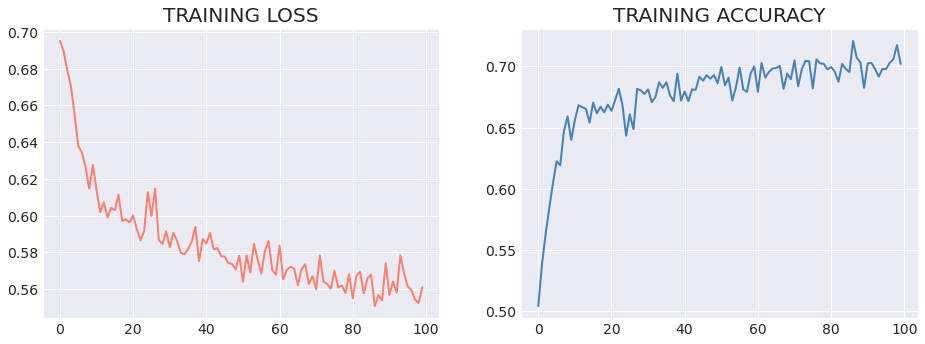

In [29]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'steelblue',lw=2);

In [25]:
#predict the validation data
predictions = model.predict_classes(bf_train_val)

### CLASSIFICATION REPORT

In [26]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.82      0.65      0.72        65
           1       0.67      0.84      0.74        55

    accuracy                           0.73       120
   macro avg       0.75      0.74      0.73       120
weighted avg       0.75      0.73      0.73       120



### CONFUSION MATRIX

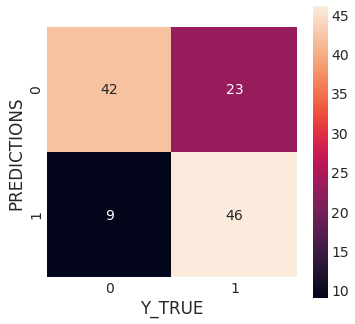

In [27]:
con_mat = confusion_matrix(y_val, predictions)
plt.figure(figsize=(5,5))

sns.heatmap(con_mat, annot=True, square=True);
plt.xlabel('Y_TRUE');
plt.ylabel('PREDICTIONS');